In [4]:
import numpy as np

def read_oscilloscope_csv_old(file_name: str, type: str="tek_tds1012") -> list:
    import csv

    if type == "tek_tds1012":
        raw_x = []
        raw_y = []

        with open(file_name, 'r') as csv_file:
            c = csv.reader(csv_file)

            in_header = True
            for row in c:
                if in_header:
                    if row[0] == 'Record Length':
                        record_length = float(row[1])
                    if row[0] == 'Sample Interval':
                        sample_interval = float(row[1])
                    if row[0] == 'Source':
                        source = str(row[1])
                    if row[0] == 'Vertical Units':
                        vertical_units = str(row[1])
                    if row[0] == 'Vertical Scale':
                        vertical_scale = float(row[1])
                    if row[0] == 'Vertical Offset':
                        vertical_offset = float(row[1])
                    if row[0] == 'Horizontal Units':
                        horizontal_units = str(row[1])
                    if row[0] == 'Horizontal Scale':
                        horizontal_scale = float(row[1])
                    if row[0] == 'Pt Fmt':
                        pt_fmt = str(row[1])
                    if row[0] == 'Yzero':
                        yzero = float(row[1])
                    if row[0] == 'Probe Atten':
                        probe_atten = float(row[1])
                    if row[0] == 'Model Number':
                        model_number = str(row[1])
                    if row[0] == 'Serial Number':
                        serial_number = str(row[1])
                    if row[0] == 'Firmware Version':
                        firmware_version = str(row[1])
                        in_header = False
                else:
                    raw_x.append(float(row[3]))
                    raw_y.append(float(row[4]))

            info_dict = {
                'Record Length': record_length,
                'Sample Interval': sample_interval,
                'Source': source,
                'Vertical Units': vertical_units,
                'Vertical Scale': vertical_scale,
                'Vertical Offset': vertical_offset,
                'Horizontal Units': horizontal_units,
                'Horizontal Scale': horizontal_scale,
                'Pt Fmt': pt_fmt,
                'Yzero': yzero,
                'Probe Atten': probe_atten,
                'Model Number': model_number,
                'Serial Number': serial_number,
                'Firmware Version': firmware_version,
            }

        return np.array(raw_x), np.array(raw_y), info_dict
    
def read_oscilloscope_csv(file_name: str) -> list:
    import csv
    
    with open(file_name, 'r') as csv_file:
        c = csv.reader(csv_file)

        index_CH1 = 1
        index_CH2 = 3
        index_CH3 = 5

        raw_x = []
        raw_y_CH1 = []
        raw_y_CH2 = []
        raw_y_CH3 = []
        probe_atten = [0,0,0]
        vertical_units = ['','','']
        vertical_offset = [0,0,0]
        vertical_scale = [0,0,0]

        in_header = True
        for row in c:
            if row:
                if in_header:
                    if row is []:
                        pass
                    if row[0] == 'Model':
                        model_number = str(row[1])
                    if row[0] == 'Firmware Version':
                        firmware_version = str(row[1])
                    if row[0] == 'Horizontal Units':
                        horizontal_units = str(row[1])
                    if row[0] == 'Horizontal Scale':
                        horizontal_scale = float(row[1])    
                    if row[0] == 'Sample Interval':
                        sample_interval = float(row[1])
                    if row[0] == 'Filter Frequency':
                        sample_interval = float(row[1])
                    if row[0] == 'Record Length':
                        record_length = float(row[1])
                    if row[0] == 'Probe Attenuation':
                        probe_atten[0] = float(row[index_CH1])
                        probe_atten[1] = float(row[index_CH2])
                        probe_atten[2] = float(row[index_CH3])
                    if row[0] == 'Vertical Units':
                        vertical_units[0] = str(row[index_CH1])
                        vertical_units[1] = str(row[index_CH2])
                        vertical_units[2] = str(row[index_CH3])
                    if row[0] == 'Vertical Offset':
                        vertical_offset[0] = float(row[index_CH1])
                        vertical_offset[1] = float(row[index_CH2])
                        vertical_offset[2] = float(row[index_CH3])
                    if row[0] == 'Vertical Scale':
                        vertical_scale[0] = float(row[index_CH1])
                        vertical_scale[1] = float(row[index_CH2])
                        vertical_scale[2] = float(row[index_CH3])
                    if row[0] == 'Label':
                        pass
                    if row[0] == 'TIME':
                        in_header = False
                else:
                    raw_x.append(float(row[0]))
                    raw_y_CH1.append(float(row[index_CH1]))
                    raw_y_CH2.append(float(row[index_CH2]))
                    raw_y_CH3.append(float(row[index_CH3]))

        info_dict = {
            'Record Length': record_length,
            'Sample Interval': sample_interval,
            'Vertical Units': vertical_units,
            'Vertical Scale': vertical_scale,
            'Vertical Offset': vertical_offset,
            'Horizontal Units': horizontal_units,
            'Horizontal Scale': horizontal_scale,
            'Probe Atten': probe_atten,
#             'Model Number': model_number,
            'Firmware Version': firmware_version,
        }
            
        return np.array(raw_x), np.array(raw_y_CH1), np.array(raw_y_CH2), np.array(raw_y_CH3), info_dict
    
def lpf(x, cutoff, fs, order=5):
    """
    low pass filters signal with Butterworth digital
    filter according to cutoff frequency

    filter uses Gustafsson’s method to make sure
    forward-backward filt == backward-forward filt

    Note that edge effects are expected

    Args:
        x      (array): signal data (numpy array)
        cutoff (float): cutoff frequency (Hz)
        fs       (int): sample rate (Hz)
        order    (int): order of filter (default 5)

    Returns:
        filtered (array): low pass filtered data
    """
    from scipy.signal import filtfilt
    from scipy.signal import butter
    import numpy as np
    
    nyquist = fs / 2
    b, a = butter(order, cutoff / nyquist)
    if not np.all(np.abs(np.roots(a)) < 1):
        raise ValueError('Filter with cutoff at {} Hz is unstable given '
                         'sample frequency {} Hz'.format(cutoff, fs))
    filtered = filtfilt(b, a, x, method='gust')
    return filtered 

def downsampling(arr, n):
    import numpy as np
    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

def reg(xdata, ydata, plot=False, weight=False):
    import matplotlib.pyplot as plt
    if weight:
        w = np.ones(len(ydata)) * 0.1
        w[0] = 1
        w[-1] = 1
        z = np.polyfit(xdata, ydata, 2, w=w)
    else:
        z = np.polyfit(xdata, ydata, 2)

    print(f'z = {z}')

    p = np.poly1d(z)

    if plot:
        plt.figure()
        plt.plot(xdata, ydata, 'b-', label='data')
        plt.plot(xdata, p(xdata), 'r-',)
        #          label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.legend()
        plt.show()

    print(f'#define a {round(z[2], 13)}f')
    print(f'#define b {round(z[1], 13)}f')
    print(f'#define c {round(z[0], 13)}f')

    return z

def testlin(x, z1, z2, lim_value):
    import numpy as np
    y = np.zeros(len(x))
    
    for i in range(len(x)):
        if x[i] < 32:
            y[i] = 0
        elif x[i] < lim_value:
            y[i] = z1[2] + z1[1] * x[i] + z1[0] * pow(x[i], 2)
        else:
            y[i] = z2[2] + z2[1] * x[i] + z2[0] * pow(x[i], 2)
    
    return y

def quantize(input: np.float, 
             number_of_bits: np.uint,
             max_value: np.float) -> np.float:
    ''' Quantizador de nível '''
    max_bits_value = pow(2, number_of_bits)
    ratio = (max_bits_value) / max_value
    converted = input * ratio
    output = np.ceil(np.clip(converted, 0, max_bits_value)) / ratio
    return output

def get_coeffs(pwlf_, verbose=True) -> np.array:
    '''
    Returns the polynomial coefficients, highest power first. 
    The coefficients for k-th segment are in p[k,:]
    '''
    
    segments = pwlf_.n_segments
    degree = pwlf_.degree
    if verbose:
        print('Number of segments: ', segments)
        print('Polynomial degree: ', degree)
    
    intercept = pwlf_.beta[0]
    breaks = pwlf_.fit_breaks
    beta = np.fliplr(pwlf_.beta[1:].reshape((degree, segments)).T)
    if verbose:
        print(f'beta: \n {beta}')
        print(f'breaks: \n {breaks}')
        print(f'intercept: \n {intercept}')
    
    coefficients = np.zeros((segments, degree+1))
    for segment in range(segments):
        print(f'segment={segment}')
        if degree is 2:
            # coefficient for degree = 2 -> p[:,0]
            coefficients[segment,0] = beta[:segment+1,0].sum()
            
            # coefficient for degree = 1 -> p[:,1]
            coefficients[segment,1] = beta[:segment+1,1].sum() \
                - 2 * np.dot(beta[:segment+1,0],breaks[:segment+1])

            # coefficient for degree = 0 -> p[:,2]
            coefficients[segment,2] = intercept \
                + np.dot(beta[:segment+1,1],(-breaks[:segment+1])**(degree-1)) \
                + np.dot(beta[:segment+1,0],(-breaks[:segment+1])**(degree-0))
            
        elif degree is 3:
            # coefficient for degree = 3 -> p[:,0]
            coefficients[segment,0] = beta[:segment+1,0].sum()
            
            # coefficient for degree = 2 -> p[:,1]
            coefficients[segment,1] = beta[:segment+1,1].sum() \
                    - 3 * np.dot(beta[:segment+1,0],breaks[:segment+1])

            # coefficient for degree = 1 -> p[:,2]
            coefficients[segment,2] = beta[:segment+1,2].sum() \
                    - 2 * np.dot(beta[:segment+1,1],breaks[:segment+1]) \
                    + 3 * np.dot(beta[:segment+1,0],breaks[:segment+1]**2)
            
            # coefficient for degree = 0 -> p[:,3]
            coefficients[segment,3] = intercept \
                    - np.dot(beta[:segment+1,2],breaks[:segment+1]) \
                    + np.dot(beta[:segment+1,1],breaks[:segment+1]**2) \
                    - np.dot(beta[:segment+1,0],breaks[:segment+1]**3)
            
        else:
            print("Error: Not implemented for degree greater than 2.")
            return
        
        alphabet = "abcdefghijklmnopqrstuvwxyz"
        for i in range(len(coefficients[segment,:])):
            print(f'#define {alphabet[i]}{segment} {round(coefficients[segment,i], 13)}f')
                    
    return coefficients

def coeffs_to_list_of_poly1d(coeffs: np.ndarray) -> list:
    p = []
    for coeff in coeffs:
        p.append(np.poly1d(coeff))
    return p

def test_coeffs(x, pwlf_, verbose=False):
    breaks = pwlf_.fit_breaks
    coeffs = get_coeffs(pwlf_)
    segments = pwlf_.n_segments
    polynomials = coeffs_to_list_of_poly1d(coeffs)
    
    y = np.zeros(len(x))
    for segment in range(segments):
        if verbose:
            print(f'segment = {segment}', end='\t')
            print(f'{breaks[segment]} <= x < {breaks[segment+1]}')
            print(polynomials[segment])
        for i in range(len(y)):
            if (x[i] >= breaks[segment]) and (x[i] < breaks[segment+1]):
                y[i] = polynomials[segment](x[i])
    return y

nan: False
nan: False
inf: False
inf: False
fs = 100000000.0


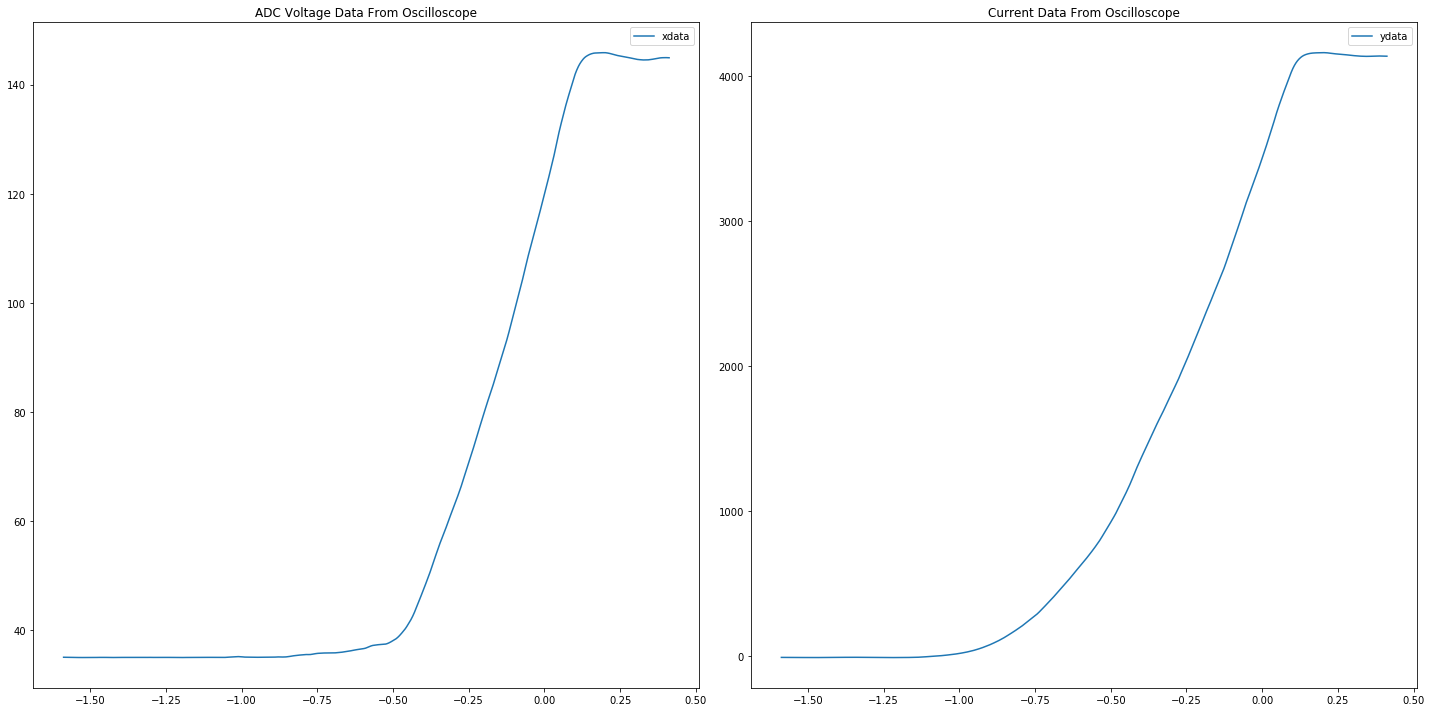

W0821 14:32:15.339424 140618330420864 legend.py:1282] No handles with labels found to put in legend.


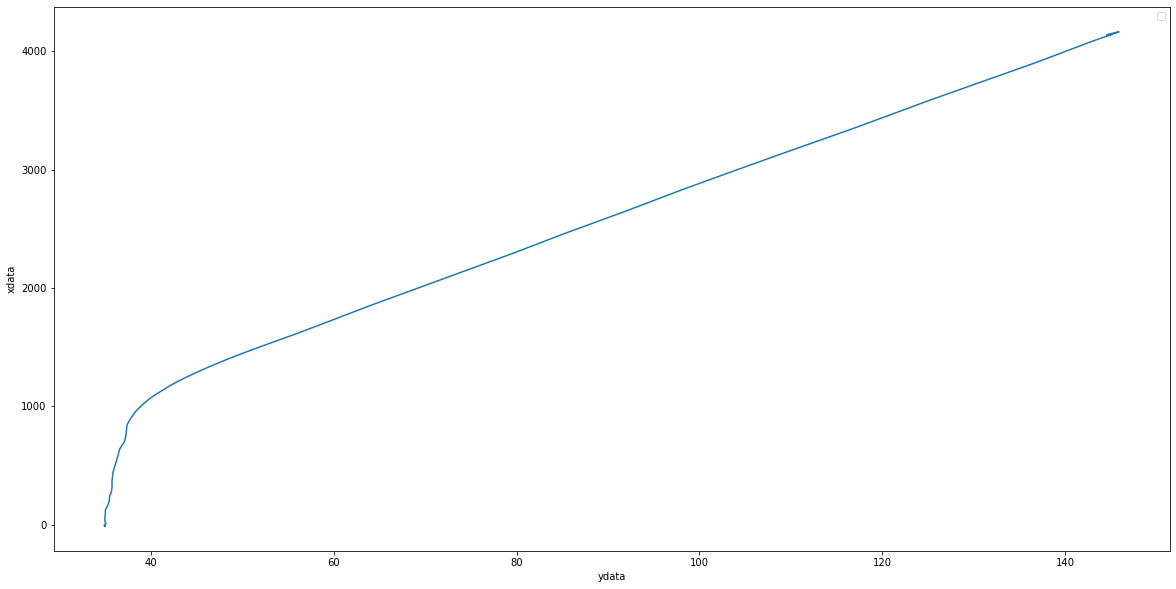

In [5]:
## READING OSCILLOSCOPE DATA
import matplotlib.pyplot as plt
import numpy as np

data_file = "sensor4/all.csv"
time, _, ydata, xdata, info_dict = read_oscilloscope_csv(data_file)

xdata *= (1024 / 5)
ydata *= 100

print(f'nan: {np.isnan(np.sum(xdata))}')
print(f'nan: {np.isnan(np.sum(ydata))}')
print(f'inf: {np.isinf(np.sum(xdata))}')
print(f'inf: {np.isinf(np.sum(ydata))}')

# Filtering data
cutoff = 1000
fs = info_dict['Sample Interval']
print(f'fs = {fs}')
xdata = lpf(x=xdata, cutoff=cutoff, fs=fs, order=1)
ydata = lpf(x=ydata, cutoff=cutoff, fs=fs, order=1)

# time offset
# xdata = xdata[round(len(xdata) * 0.30):round(len(xdata) * 0.85)]
# ydata = ydata[round(len(ydata) * 0.30):round(len(ydata) * 0.85)]
# time = time[round(len(time) * 0.30):round(len(time) * 0.85)]

# Downsampling
downsampling_factor = 10
time = downsampling(time, downsampling_factor)
xdata = downsampling(xdata, downsampling_factor)
ydata = downsampling(ydata, downsampling_factor)

# xdata = quantize(xdata, 10, 1023).astype(np.int)

# Plot
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(time, xdata, label='xdata')
plt.legend()
plt.title('ADC Voltage Data From Oscilloscope')
plt.subplot(1, 2, 2)
plt.plot(time, ydata, label='ydata')
plt.legend()
plt.title('Current Data From Oscilloscope')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(xdata, ydata)
plt.legend()
plt.xlabel('ydata')
plt.ylabel('xdata')
plt.show()

Number of segments:  2
Polynomial degree:  3
beta: 
 [[  5.02803545 -84.00893338 510.82887613]
 [ -5.02791231 -29.01364251 -68.53349322]]
breaks: 
 [ 34.91973457  42.41073226 145.87618674]
intercept: 
 -14.584450827270711
segment=0
#define a0 5.0280354530032f
#define b0 -610.7419236991338f
#define c0 24771.344399310852f
#define d0 -334389.3386753971f
segment=1
#define a1 0.0001231439852f
#define b1 -0.0432378954688f
#define c1 33.1222745397372f
#define d1 -124.92136697151f


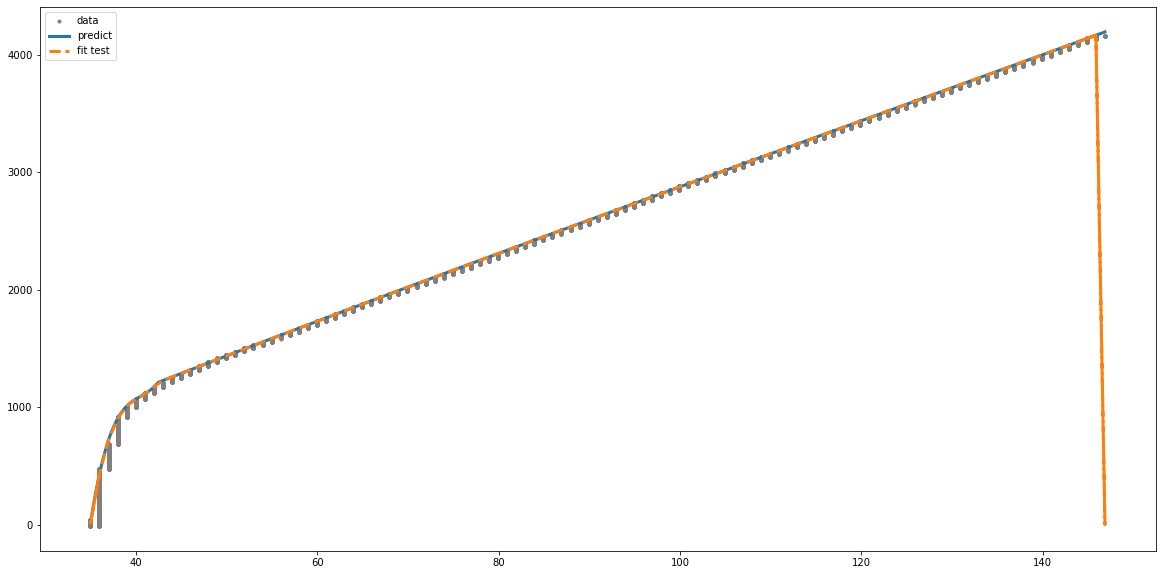

In [6]:
import pwlf
import numpy as np
import matplotlib.pyplot as plt

degree = 3
segments = 2

xdata_q = quantize(xdata, 10, 1023)

my_pwlf = pwlf.PiecewiseLinFit(xdata, ydata, degree=degree, disp_res=False)
res = my_pwlf.fit(segments)

# predict
xdataHat = np.linspace(min(xdata_q), max(xdata_q), num=10000)
ydataHat = my_pwlf.predict(xdataHat)

# test getting polynomial coefficients
ydatatest = test_coeffs(xdata_q, my_pwlf)

plt.figure(figsize=(20,10))
plt.plot(xdata_q, ydata, '.', lw=3, c='gray', label='data')
plt.plot(xdataHat, ydataHat, '-', lw=3, label='predict')
plt.plot(xdata_q, ydatatest, '--', lw=3, label='fit test')
plt.legend()
plt.show()